In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from collections import OrderedDict

plt.style.use('ggplot')

# Feature importances for WaterXr

Rough code for estimating feature importances using a Random Forest. The most complicated part of this workflow is deciding how to handle NaNs in a sensible way. This is because the sampling strategy at Vansjø is strongly biased over time (sampling only takes place between spring and autumn). This produces regular periods of NaNs in the data series, which affect the calculations for lagged variables.

## 1. Read data

In [2]:
# Read Leah's data matrix
in_csv = r'../../../data/DataMatrices/dataMatrix_monthly_TP_Van1.csv'
df = pd.read_csv(in_csv)

# Parse dates and tidy
df['Date'] = pd.to_datetime(df['Date'])
df.columns = df.columns.str.lower()
df.set_index('date', inplace=True)

df.head()

,tp_catch,temp,pptn_intense,rain_day,q,tp_flux,pptn,tp_lake,status_tp_lake,tp_catch_lag1m,...,tp_catch_lag3m_av,temp_lag2m_av,temp_lag3m_av,q_lag2m_av,q_lag3m_av,tp_lake_lag2m_av,tp_lake_lag3m_av,season,status_tp_lake_prevsummer,tp_lake_prevsummer
date,,,,,,,,,,,,,,,,,,,,,
1980-03-31,NaN,-3.762903,1,10,0.354483,NaN,42.6,39.500000,PB,NaN,...,NaN,-8.330228,NaN,2.270767,NaN,NaN,NaN,spr,NaN,NaN
1980-04-30,130.0,4.448333,0,6,10.469966,383.595500,11.0,53.559028,PB,NaN,...,NaN,-6.287486,-6.807786,0.350920,1.632005,NaN,NaN,spr,NaN,NaN
1980-05-31,50.0,11.608065,1,11,4.493129,1002.243593,58.5,67.075000,PB,130.0,...,NaN,0.342715,-2.708880,5.412224,3.723935,46.529514,NaN,spr,NaN,NaN
1980-06-30,80.0,15.750000,7,22,4.847633,943.123639,123.7,24.444444,M,50.0,...,NaN,8.028199,4.097832,7.481547,5.105859,60.317014,53.378009,summ,NaN,NaN
1980-07-31,75.0,16.761290,0,19,3.749762,518.558899,37.6,22.888889,M,80.0,...,86.666667,13.679032,10.602133,4.670381,6.603576,45.759722,48.359491,summ,NaN,NaN


## 2. Encode variables

In addition to continuous variables, we also have two kinds of categorical variable: **ordinal** and **nominal**. Ordinal data consists of *ordered* classes, such as water quality status where e.g. `'HG'` represents higher quality than `'M'`, which is higher than `'PB'`. The nominal categories are *unordered* (month and season, for example). 

### 2.1. Ordinal data

I will reclassify water quality status using an integer scale, where 0 corresponds to `'PB'` and 2 corresponds to `'HG'`.

In [3]:
# Category mappings
status_dict = {'HG':2,
               'M':1,
               'PB':0}

# Columns with ordinal data
ord_cols = ['status_tp_lake', 'status_tp_lake_lag1m', 'status_tp_lake_prevsummer']

# Reclassify
for col in ord_cols:
    df[col] = df[col].replace(status_dict)

### 2.2. Nominal

The nominal data can be represented using "[one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)", which generates $(n - 1)$ binary features from a column with $n$ categories.

In [4]:
# One hot encoding for nominal columns
df = pd.get_dummies(df, 
                    {'month':'month',
                     'season':'season',
                     'season_2':'season2'},
                    columns=['month', 'season', 'season_2'],
                    drop_first=True)

## 3. Filling missing data

Most ML algorithms don't like missing data. The code below calculates the proportion of missing values in each column.

In [5]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = 100 * missing['total'] / len(df)
missing.sort_values('percent', ascending=False).head(10)

,total,percent
tp_lake_lag3m_av,118,58.415842
tp_flux_lag6m_sum,105,51.980198
tp_flux_lag5m_sum,96,47.524752
tp_flux_lag4m_sum,87,43.069307
tp_lake_lag2m_av,82,40.594059
tp_flux_lag3m_sum,81,40.099010
tp_flux_lag2m_sum,74,36.633663
tp_flux,68,33.663366
tp_flux_lag1m,67,33.168317
tp_flux_wintersum,62,30.693069


Filling these gaps sensibly is not easy. In the code below, I've used the following strategy:

 1. For **continuous** variables, fill missing values with the *median* for the month in question
 
 2. For **Ordinal** variables, fill missing values with the most common (i.e. modal) value for the month in question
 
There are no missing values for the **nominal** variables, since they're all derived from the date-time index, which is complete.

**Note:** Filling NaNs in this way transfers information between samples (i.e. rows) in the dataset. This violates the assumption that each row can be treated as an independent sample and may bias the model evaluation performed below. Ideally, we would retain a completely independent testing dataset for final model evaluation, but we don't have enough data for that here.

In [6]:
# loop over columns
for col in df.columns:
    if col in ord_cols:
        # Ordinal data. Get modal value for each month
        patch = df.groupby(df.index.month)[col].apply(pd.Series.mode).loc[:, 0]

    else:
        # Contiuous data. Get median value for each month
        patch = df.groupby(df.index.month)[col].median()
        
    # Loop over rows
    for idx, row in df.iterrows():
        if pd.isnull(row[col]):
            try:
                # Try to fill with patches value for this month
                fill_val = patch.loc[idx.month]
                df.loc[idx, col] = fill_val
            except KeyError:
                # No data available for this month. Leave as NaN
                pass

How effective has this startegy been at filling NaNs?

In [7]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = 100 * missing['total'] / len(df)
missing.sort_values('percent', ascending=False).head(10)

,total,percent
tp_lake_lag3m_av,44,21.782178
tp_lake_lag2m_av,22,10.891089
status_tp_lake_lag1m,8,3.960396
tp_lake_lag1m,8,3.960396
tp_catch_lag1m,1,0.495050
tp_flux_wintersum,1,0.495050
tp_flux_lag1m,1,0.495050
tp_flux_lag2m_sum,1,0.495050
tp_flux_lag4m_sum,1,0.495050
tp_catch,1,0.495050


This is better. For the remaining NaNs, I could either fill values using the overall mean/median for each column, or simply drop the rows that still contain NaN. After a bit of experimentation, I think the best option is to drop the NaNs, rather than apply more arbitrary data patching.
 
## 4. Random forest modelling

### 4.1. Drop any remaining NaNs

In [8]:
df2 = df.dropna(how='any')
print('Length of original dataset:', len(df))
print('Length of trimmed dataset: ', len(df2))

Length of original dataset: 202
Length of trimmed dataset:  158


This method loses roughly a quarter of the data, which is not ideal.

### 4.2. Fit model

I'll begin by choosing `'tp_lake'` as the target variable of interest. 

In [9]:
# Define target and response vars
target_var = 'tp_lake'
exp_vars = [i for i in df2.columns if i != target_var]

Random Forests use "bootstrapping" to partition the data used by each tree. Data not included in each bootstrap sample can therefore be used to perform "internal" validation, without the need for a holdout dataset as is usual for cross-validation. This approach is usually referred to as the "out-of-bag" (OOB) validation score. In sci-kit learn, this is roughly equivalent to $R^2$, but calculated on "unseen" data (as opposed to the less stringent "within-sample" $R^2$ typically reported for OLS regression).

OOB scores are not *exactly* the same as cross-validation but, under typical circumstances, the OOB score should be roughly comparable to 3-fold CV (see e.g. [here](https://stats.stackexchange.com/a/199201/5467) and [here](https://stats.stackexchange.com/a/208018/5467) for some discussion). When using OOB scores, it is not necessary to split the data into training and testing sets, which is a big advantage when data are limited (as is the case here). Ideally, validation using a test set should also be performed, but for the work here I'm going to focus on OOB scores in order to make the most of limited data.

Random Forests have a number of hyperparameters that can be tuned to improve performance. Of these, the most important seem to be `'n_estimators'` (the number of treesin the forest) and `'max_features'` (the size of the random subsets of features to consider when splitting a node). There is some debate about the best values to choose for `'max_features'`: the default for regression problems in sci-kit learn is `'max_features' = 'n_features'`, whereas in R the recommended value is to use about one third of the total number of features (see the comments on [this](https://stackoverflow.com/a/23950648/505698) post and the references in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for details).

The code below (modified from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)) plots the OOB error rate (= `1 - OOB_Score`) as a function of `'n_estimators'` for various choices for `'max_features'`. 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


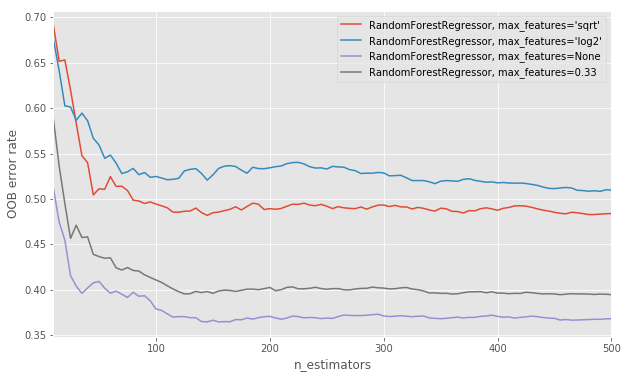

In [10]:
# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# For reproducibility
rand_state = 42

# List classifiers of interest
# NB: Setting the `warm_start=True` disables parallel support, but is necessary for 
# tracking the OOB error trajectory during training
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              oob_score=True,
                              max_features="sqrt",
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features='log2',
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=None",                  
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=None,           # Default. Uses all feats
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=0.33",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=0.33,           # Older recommendation. Used by R
                              oob_score=True,
                              random_state=rand_state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore
min_estimators = 10
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_scaled, y)

        # Record the OOB error 
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot
fig = plt.figure(figsize=(10,6))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

Based on the plot above, the error rate is lowest when  `'max_features' = 'n_features'` (i.e. the new sci-kit learn default of `'None'`) and the error stabilises after about `'n_estimators = 200'`. These parameters are used below to estimate feature importances.

### 4.3. Feature importances

In [11]:
# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=200,
                              warm_start=False, 
                              max_features=None,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.63


,importance
status_tp_lake,0.624007
q,0.046533
temp,0.035653
tp_lake_lag1m,0.025855
tp_catch_lag3m_av,0.017688
pptn_lag1m,0.012743
rain_day_lag1m,0.012574
tp_catch_lag1m,0.011577
q_lag2m_av,0.010999
pptn,0.010881


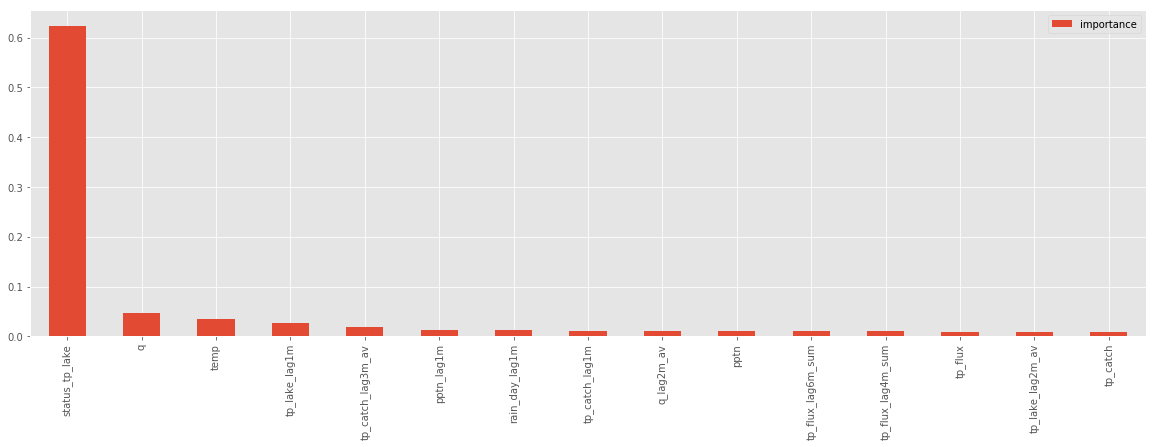

In [12]:
# Plot
res_df[:15].plot(kind='bar', figsize=(20,6))

This model is quite good (an OOB score of 0.63), but the results are not very interesting because the output is overwhelmingly dominated by `'status_tp_lake'` (which is essentially just the target variable re-expressed in ordinal form). This isn't useful, but it does at least suggest the model is performing sensibly.

In reality, we are hoping to make forecasts a few months ahead. This means that any contemporary or `'_lag1m'` variables will not be available. The code below removes these and tries again.

### 4.4. Remove unrealistic features

In [13]:
# Remove unrealistic explanatory vars
exp_vars = [i for i in exp_vars if i.split('_')[-1]!='lag1m']
exp_vars.remove('status_tp_lake')

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


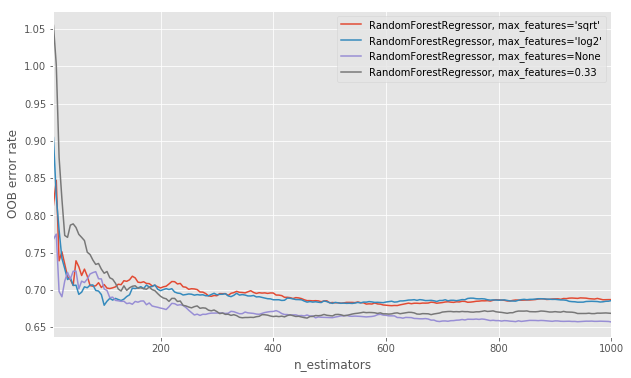

In [14]:
# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# For reproducibility
rand_state = 42

# List classifiers of interest
# NB: Setting the `warm_start=True` disables parallel support, but is necessary for 
# tracking the OOB error trajectory during training
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              oob_score=True,
                              max_features="sqrt",
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features='log2',
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=None",                  
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=None,           # Default. Uses all feats
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=0.33",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=0.33,           # Older recommendation. Used by R
                              oob_score=True,
                              random_state=rand_state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore
min_estimators = 10
max_estimators = 1000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_scaled, y)

        # Record the OOB error 
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot
fig = plt.figure(figsize=(10,6))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

The first thing to notice here is that removing `'status_tp_lake'` and the `'_lag1m'` variables has a dramatic negative impact on model performance: error rates have increased from about 0.37 to 0.66, and the best OOB score has reduced from 0.63 to 0.34 (see below). The plot also suggests using more trees for this dataset: something like 700 - 800 seems to be the best.

In [15]:
# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=800,
                              warm_start=False, 
                              max_features=None,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.34


,importance
tp_lake_lag2m_av,0.132995
q,0.112017
rain_day_lag6m_sum,0.082596
pptn_lag6m_sum,0.070688
tp_catch_lag3m_av,0.060693
temp,0.038806
q_lag2m_av,0.035878
tp_flux_lag2m_sum,0.034430
tp_flux_wintersum,0.029452
tp_catch_lag2m_av,0.027293


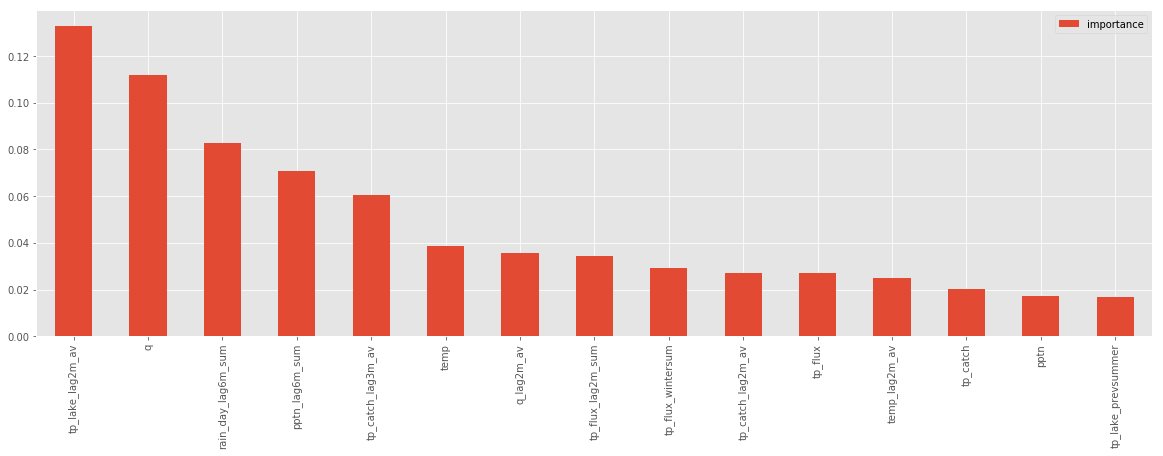

In [16]:
# Plot
res_df[:15].plot(kind='bar', figsize=(20,6))

Based on this, the most important features are:

 * Average TP concentration both in the lake and in the Hobølelva at Kure over the previous 2-3 months (no surprise that these are closely related to TP at the time of interest) <br><br>
 
 * Monthly average discharge ($q$) <br><br>
 
 * The total number of rainy days and the total precipitation over the previous 6 months. **Note:** These two varaibles are closely correlated. I have tried removing the one with the least weight (`'pptn_lag6m_sum'`), but it doesn't make a noticable difference either to model performance or to the ordering of variables. I think the basic conclusion is that some metric indicating rainfall over the previous 6 months is useful <br><br>
 
 * Mean monthly temperature
 
### 4.5. Recursive feature elimination

Recursive feature elimination attempts to find the best model using subsets of the available features. This is essentially the same as "stepwise" regression, except here we're using CV to avoid overfitting (as opposed to traditional "significance testing"). In the code below, I've used out-of-sample $R^2$ as a measure of performance. The best values obtained are pretty low, but remember that out-of-sample tests are much more stringent than their within-sample equivalents. The best overall indicator of perfornmance used in this notebook is the OOB score.

**Note:** Other scoring metrics are available. Use 

    sorted(sklearn.metrics.SCORERS.keys())
    
to print a list.

In [17]:
# Build same model as above
model = RandomForestRegressor(n_estimators=800,
                              warm_start=False, 
                              max_features=None,           
                              oob_score=True,
                              random_state=rand_state)

# Feature elimination with 3-fold CV
rfecv = RFECV(estimator=model, 
              step=1, 
              cv=3, 
              scoring='r2',
              n_jobs=-1)

selector = rfecv.fit(X_scaled, y)

Optimal number of features: 12

Optimal features (in no particular order):
   temp
   q
   tp_flux_wintersum
   pptn_lag4m_sum
   pptn_lag6m_sum
   tp_flux_lag2m_sum
   rain_day_lag6m_sum
   tp_catch_lag2m_av
   tp_catch_lag3m_av
   temp_lag2m_av
   q_lag2m_av
   tp_lake_lag2m_av


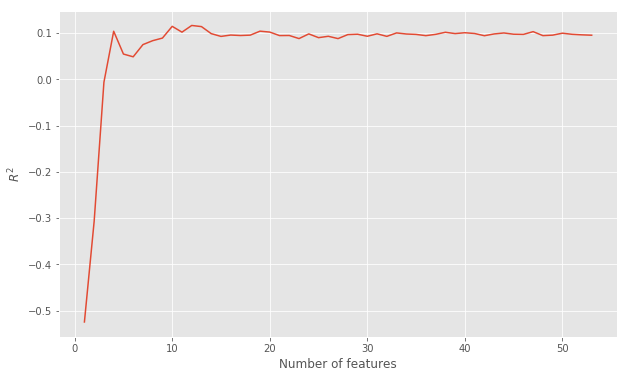

In [18]:
print('Optimal number of features: %d' % rfecv.n_features_)
print('')
print ('Optimal features (in no particular order):')
for i in np.array(exp_vars)[selector.support_]:
    print('  ', i)
    
# Plot number of features vs. cross-validation score
plt.figure(figsize=(10,6))
plt.xlabel('Number of features')
plt.ylabel('$R^2$')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

The best model uses 12 features (out of more than 50). However, it's pretty clear from the plot above that performance levels-off from around 10 features onwards, and reasonable scores can be obtained with just 4 features. Looking at the list above, several of the selected features likely contain duplicated information (e.g. `'tp_catch_lag2m_av'` and `'tp_catch_lag3m_av'` will be very similar). Removing these gives the following consolidated list:

    temp
    q
    tp_flux_wintersum
    pptn_lag6m_sum
    tp_flux_lag2m_sum
    tp_catch_lag3m_av
    tp_lake_lag2m_av
    
How does this model perform?

In [19]:
# Reduce list of exp vars based on results above
exp_vars = ['temp', 'q', 'tp_flux_wintersum', 'pptn_lag6m_sum', 
            'tp_flux_lag2m_sum', 'tp_catch_lag3m_av', 'tp_lake_lag2m_av']

# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

In [20]:
# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=800,
                              warm_start=False, 
                              max_features=None,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.37


,importance
tp_lake_lag2m_av,0.225695
q,0.194079
pptn_lag6m_sum,0.179992
tp_flux_lag2m_sum,0.117866
tp_catch_lag3m_av,0.111752
temp,0.101861
tp_flux_wintersum,0.068755


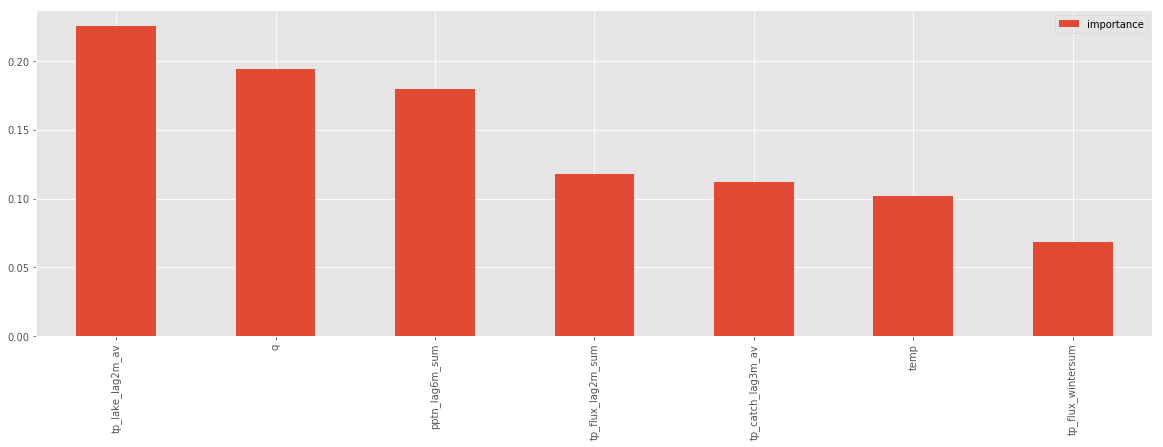

In [21]:
# Plot
res_df[:15].plot(kind='bar', figsize=(20,6))

This version of the model actually performs *better* than the "full" thing with 50+ features (OOB score of 0.37 here compared to 0.34 above). This difference is marginal, and likely due to random chance more than anything else. The main conclusion, though, is that performance can be maintained using just a few features. For further work, I suggest using some sensible combination of the 7 - 12 features identified above.